In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook

from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## 6.8.1 Make predictions on the simulated ARMA(1,1) process 

In [2]:
np.random.seed(42)

ar1 = np.array([1, -0.33])
ma1 = np.array([1, 0.9])

ARMA_1_1 = ArmaProcess(ar1, ma1).generate_sample(nsample=1000)

In [3]:
df = pd.DataFrame({'value': ARMA_1_1})

train = df[:800]
test = df[800:]

In [4]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
            
        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'ARMA':
        pred_ARMA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(1,0,1))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARMA.extend(oos_pred)
            
        return pred_ARMA

In [6]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1

pred_mean = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_ARMA = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'ARMA')

test.loc[:, 'pred_mean'] = pred_mean
test.loc[:, 'pred_last_value'] = pred_last_value
test.loc[:, 'pred_ARMA'] = pred_ARMA

test.head()

,value,pred_mean,pred_last_value,pred_ARMA
800,1.084218,-0.022669,0.361071,0.146811
801,0.686203,-0.021287,1.084218,1.183808
802,-0.141873,-0.020405,0.686203,-0.255567
803,-0.422585,-0.020556,-0.141873,0.062876
804,-0.989997,-0.021056,-0.422585,-0.571610


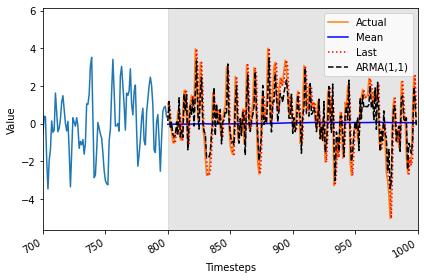

In [7]:
fig, ax = plt.subplots()

ax.plot(train)
ax.plot(test['value'], label='Actual')
ax.plot(test['pred_mean'], 'b-', label='Mean')
ax.plot(test['pred_last_value'], 'r:', label='Last')
ax.plot(test['pred_ARMA'], 'k--', label='ARMA(1,1)')

ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

ax.legend(loc='best')

ax.axvspan(800, 1000, color='#808080', alpha=0.2)

plt.xlim(700, 1000)
fig.autofmt_xdate()
plt.tight_layout()

In [8]:
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(test['value'], test['pred_mean'])
mse_last = mean_squared_error(test['value'], test['pred_last_value'])
mse_ARMA = mean_squared_error(test['value'], test['pred_ARMA'])

print(mse_mean, mse_last, mse_ARMA)

2.6792528451659092 1.6761458178498734 0.9281958689162179


## 6.8.2 Simulate an ARMA(2,2) process and make forecasts 

In [9]:
np.random.seed(42)

ma2 = np.array([1, 0.9, 0.3])
ar2 = np.array([1, -0.33, -0.50])

ARMA_2_2 = ArmaProcess(ar2, ma2).generate_sample(nsample=10000)

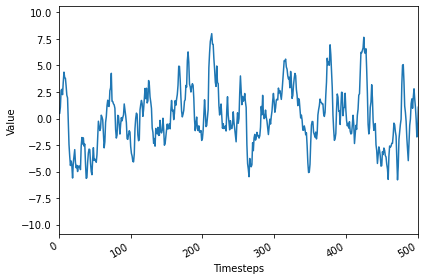

In [11]:
fig, ax = plt.subplots()

ax.plot(ARMA_2_2)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

plt.xlim(0, 500)

fig.autofmt_xdate()
plt.tight_layout()

In [12]:
ADF_result = adfuller(ARMA_2_2)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -20.684894435243283
p-value: 0.0


In [15]:
df = pd.DataFrame({'value': ARMA_2_2})

train = df[:-200]
test = df[-200:]

print(len(train))

9800


In [16]:
from typing import Union

def optimize_ARMA(endog: Union[pd.Series, list], order_list: list) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(endog, order=(order[0], 0, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [17]:
ps = range(1, 4, 1)
qs = range(1, 4, 1)

order_list = list(product(ps, qs))

In [18]:
result_df = optimize_ARMA(train['value'], order_list)
result_df

  0%|          | 0/9 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(3, 2)",27905.101691
1,"(2, 3)",27905.310112
2,"(2, 2)",27905.573367
3,"(3, 3)",27907.356959
4,"(1, 3)",27917.375642
5,"(1, 2)",27965.143311
6,"(3, 1)",27984.569852
7,"(2, 1)",28010.581548
8,"(1, 1)",28085.205818


Just like in the chapter, we see that an ARMA(3,2) or ARMA(2,3) have a slightly lower AIC, however we are looking at the decimal places. Here, we can reasonably go with the ARMA(2,2) model and have accurate predictions.

In [19]:
model = SARIMAX(train['value'], order=(2,0,2), simple_differencing=False)
model_fit = model.fit(disp=False)

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                 9800
Model:               SARIMAX(2, 0, 2)   Log Likelihood              -13947.787
Date:                Mon, 10 Jan 2022   AIC                          27905.573
Time:                        13:59:30   BIC                          27941.524
Sample:                             0   HQIC                         27917.755
                               - 9800                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3470      0.052      6.721      0.000       0.246       0.448
ar.L2          0.4757      0.048     10.010      0.000       0.383       0.569
ma.L1          0.8683      0.050     17.244      0.0

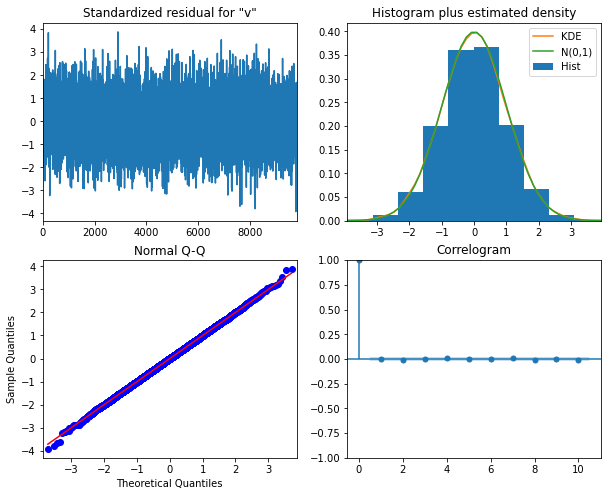

In [20]:
model_fit.plot_diagnostics(figsize=(10, 8));

In [23]:
residuals = model_fit.resid

lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))

print(pvalue)

[0.83705578 0.81282011 0.91580213 0.93581087 0.97576083 0.98257749
 0.95540329 0.9289937  0.96007836 0.96989363]


In [24]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
            
        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'ARMA':
        pred_ARMA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(2,0,2))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARMA.extend(oos_pred)
            
        return pred_ARMA

In [26]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_ARMA = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'ARMA')

test.loc[:, 'pred_mean'] = pred_mean
test.loc[:, 'pred_last_value'] = pred_last_value
test.loc[:, 'pred_ARMA'] = pred_ARMA

test.head()

,value,pred_mean,pred_last_value,pred_ARMA
9800,-0.275170,-0.025645,-0.837188,-1.182182
9801,0.479336,-0.025645,-0.837188,-1.137223
9802,3.059285,-0.025619,0.479336,0.736508
9803,2.459694,-0.025619,0.479336,0.627930
9804,2.941582,-0.025051,2.459694,2.100925


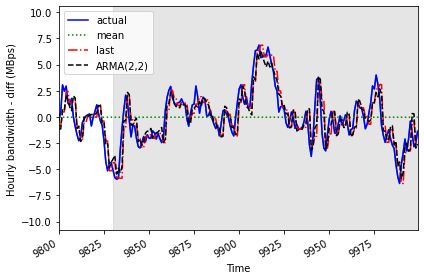

In [27]:
fig, ax = plt.subplots()

ax.plot(df['value'])
ax.plot(test['value'], 'b-', label='actual')
ax.plot(test['pred_mean'], 'g:', label='mean')
ax.plot(test['pred_last_value'], 'r-.', label='last')
ax.plot(test['pred_ARMA'], 'k--', label='ARMA(2,2)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwidth - diff (MBps)')

ax.axvspan(9830, 9999, color='#808080', alpha=0.2)

ax.set_xlim(9800, 9999)

fig.autofmt_xdate()
plt.tight_layout()

In [28]:
mse_mean = mean_squared_error(test['value'], test['pred_mean'])
mse_last = mean_squared_error(test['value'], test['pred_last_value'])
mse_ARMA = mean_squared_error(test['value'], test['pred_ARMA'])

print(mse_mean, mse_last, mse_ARMA)

6.263912001945173 2.1552606973982593 1.759849420619059
